# RFE With Cross Validation

Import libraries

In [ ]:
import re

#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import swifter
from nltk.corpus import wordnet
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.inspection import permutation_importance

Import Data

In [ ]:
data = pd.read_pickle("train_preprocess_final.pkl")

In [ ]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_tokenised', 'question2_tokenised', 'question1_standardised',
       'question2_standardised', 'is_equal', 'question1_standardised_tokens',
       'question2_standardised_tokens', 'question_len',
       'longest_common_substring', 'gestalt_ratio', 'levenshtein_ratio',
       'jaro_ratio', 'jaro_winkler_ratio', 'bigram_similarity',
       'trigram_similarity', 'question1_standardised_str',
       'question2_standardised_str', 'count_similarity', 'tfidf_similarity',
       'word2vec_similarity', 'is_same_category', 'shared_word_percentage',
       'word_mover_distance', 'question1_distilbert_vec',
       'question2_distilbert_vec', 'quora_distilbert_similarity',
       'question1_2_distilbert_vec'],
      dtype='object')

Resampling

In [ ]:
undersize = data[data.is_duplicate == 1].shape[0]
resample = data[data.is_duplicate == 0].sample(n = undersize).append(data[data.is_duplicate == 1])

In [ ]:
feature_cols = ['is_equal', 'question_len',
       'longest_common_substring', 'gestalt_ratio', 'levenshtein_ratio',
       'jaro_ratio', 'jaro_winkler_ratio', 'bigram_similarity',
       'trigram_similarity', 'count_similarity', 'tfidf_similarity',
       'word2vec_similarity', 'is_same_category', 'shared_word_percentage',
       'word_mover_distance', 'quora_distilbert_similarity']
X = data[feature_cols]
y = data.is_duplicate

In [ ]:
feature_cols = ['is_equal', 'question_len',
       'longest_common_substring', 'gestalt_ratio', 'levenshtein_ratio',
       'jaro_ratio', 'jaro_winkler_ratio', 'bigram_similarity',
       'trigram_similarity', 'count_similarity', 'tfidf_similarity',
       'word2vec_similarity', 'is_same_category', 'shared_word_percentage',
       'word_mover_distance', 'quora_distilbert_similarity']
Xres = resample[feature_cols]
yres = resample.is_duplicate

# Decision Tree 

Feature importance with original data 

In [ ]:
skf = StratifiedKFold()
clf = DecisionTreeClassifier()
decision_tree_scores = cross_val_score(clf, X, y, cv=skf)

In [ ]:
print("Decision tree: %0.3f accuracy with a standard deviation of %0.3f" % (decision_tree_scores.mean(), decision_tree_scores.std()))

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = DecisionTreeClassifier()
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 16


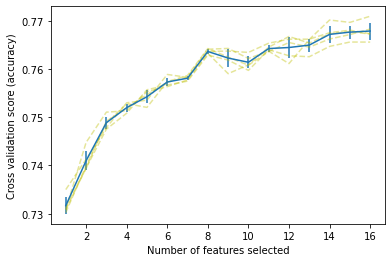

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'], rfecv.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

Feature importance with resampled data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = DecisionTreeClassifier()
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(Xres, yres)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 15


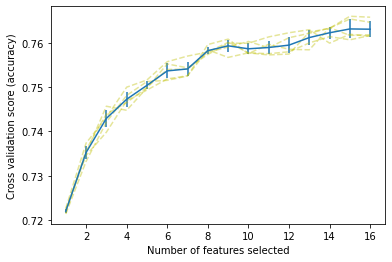

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'], rfecv.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

In [ ]:
clf = DecisionTreeClassifier()
rfe = RFE(estimator = clf, n_features_to_select = 1)
rfe.fit(X,y)

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=1)

Show the feature importance rank

In [ ]:
ranking = rfe.ranking_

In [ ]:
ranking 

array([16, 10, 12,  6, 11,  4, 13,  7,  9, 14,  3,  5, 15,  8,  2,  1])

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
a1 = clf.feature_importances_
b1 = a1.tolist()

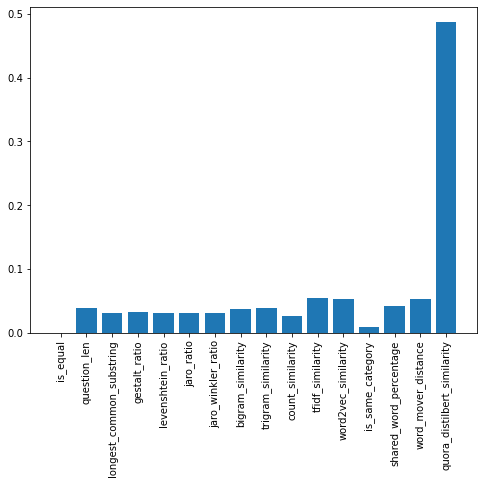

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(xlabel, b1)
plt.show()

# Random Forest 

Feature importance with original data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
min_features_to_select = 1  # Minimum number of features to consider
rfecv1 = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv1.fit(X, y)

print("Optimal number of features : %d" % rfecv1.n_features_)



Optimal number of features : 16


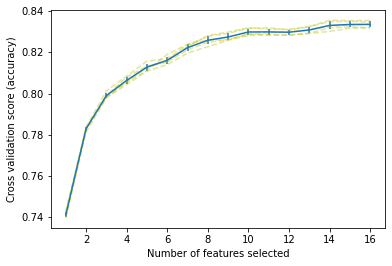

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv1.grid_scores_) + min_features_to_select),
    rfecv1.cv_results_['mean_test_score'], rfecv1.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv1.grid_scores_) + min_features_to_select),
    rfecv1.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

Feature importance with resampled data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
min_features_to_select = 1  # Minimum number of features to consider
rfecv1bal = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv1bal.fit(Xres, yres)

print("Optimal number of features : %d" % rfecv1bal.n_features_)

Optimal number of features : 15


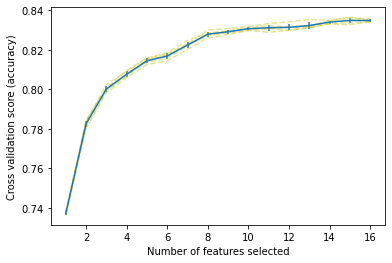

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv1bal.grid_scores_) + min_features_to_select),
    rfecv1bal.cv_results_['mean_test_score'], rfecv1bal.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv1bal.grid_scores_) + min_features_to_select),
    rfecv1bal.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

In [ ]:
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
rfe2 = RFE(estimator = clf, n_features_to_select = 1)
rfe2.fit(X,y)

RFE(estimator=RandomForestClassifier(class_weight='balanced', random_state=0),
    n_features_to_select=1)

Show the feature importance rank

In [ ]:
ranking2 = rfe2.ranking_

In [ ]:
ranking2

array([16, 13, 14,  5, 11, 12,  9,  6,  3, 10,  7,  8, 15,  4,  2,  1])

In [ ]:
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
clf.fit(X,y)
a2 = clf.feature_importances_

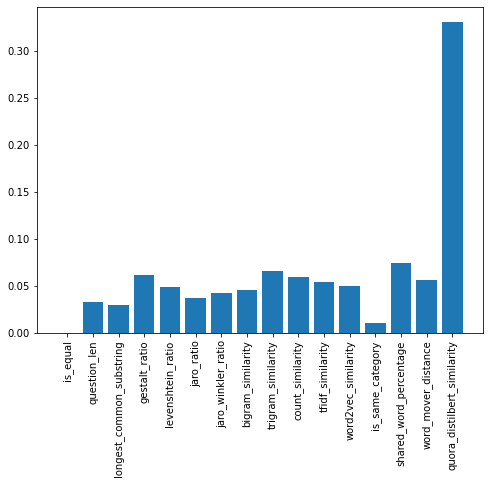

In [ ]:
b2 = a2.tolist()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(xlabel, b2)
plt.show()

# Logistic Regression 

Feature importance with original data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = LogisticRegression(class_weight='balanced', max_iter = 1000)
min_features_to_select = 1  # Minimum number of features to consider
rfecv2 = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv2.fit(X, y)

print("Optimal number of features : %d" % rfecv2.n_features_)

Optimal number of features : 15


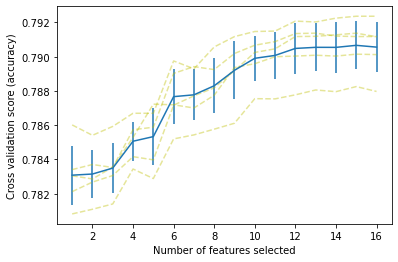

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv2.grid_scores_) + min_features_to_select),
    rfecv2.cv_results_['mean_test_score'], rfecv2.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv2.grid_scores_) + min_features_to_select),
    rfecv2.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

Feature importance with resampled data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = LogisticRegression(class_weight='balanced', max_iter = 1000)
min_features_to_select = 1  # Minimum number of features to consider
rfecv2bal = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv2bal.fit(Xres, yres)

print("Optimal number of features : %d" % rfecv2bal.n_features_)

Optimal number of features : 15


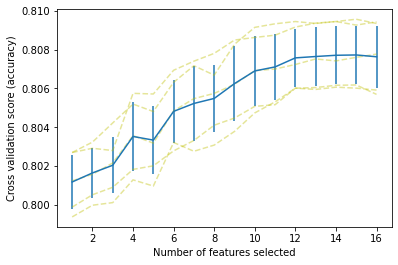

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv2bal.grid_scores_) + min_features_to_select),
    rfecv2bal.cv_results_['mean_test_score'], rfecv2bal.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv2bal.grid_scores_) + min_features_to_select),
    rfecv2bal.grid_scores_, 'y--', alpha = 0.4
)
plt.show()

In [ ]:
clf = LogisticRegression(class_weight='balanced', max_iter = 1000)
rfe3 = RFE(estimator = clf, n_features_to_select = 1)
rfe3.fit(X,y)

RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    n_features_to_select=1)

Show the feature importance rank

In [ ]:
ranking3 = rfe3.ranking_

In [ ]:
ranking3 

array([12, 13,  6,  4,  5,  2,  3, 11,  7,  8,  9, 14, 16, 15, 10,  1])

In [ ]:
clf = LogisticRegression(class_weight='balanced', max_iter = 1000)
clf.fit(X,y)
a3 = clf.coef_
b3 = a3.tolist()[0]

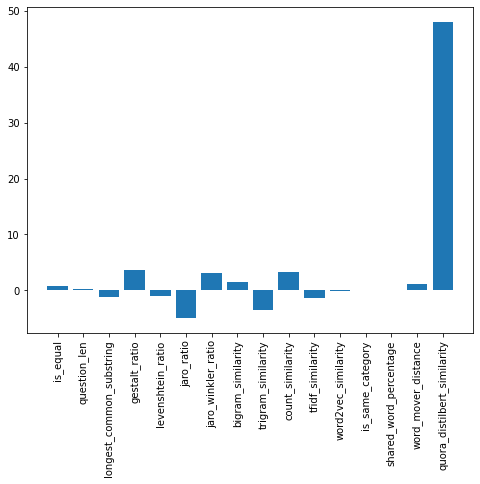

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(xlabel, b3)
plt.show()

# SVM

Feature importance with original data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = LinearSVC(class_weight='balanced')
min_features_to_select = 1  # Minimum number of features to consider
rfecv3 = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv3.fit(X, y)

print("Optimal number of features : %d" % rfecv3.n_features_)

Optimal number of features : 13


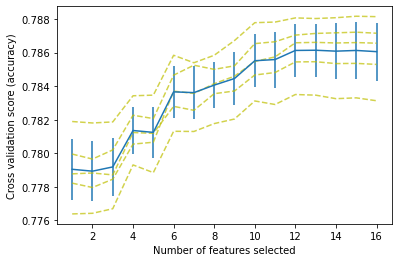

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv3.grid_scores_) + min_features_to_select),
    rfecv3.cv_results_['mean_test_score'], rfecv3.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv3.grid_scores_) + min_features_to_select),
    rfecv3.grid_scores_, 'y--', alpha = 0.7
)
plt.show()

Feature importance with resampled data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = LinearSVC(class_weight='balanced')
min_features_to_select = 1  # Minimum number of features to consider
rfecv3bal = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv3bal.fit(Xres, yres)

print("Optimal number of features : %d" % rfecv3.n_features_)

In [ ]:
print("Optimal number of features : %d" % rfecv3bal.n_features_)

Optimal number of features : 14


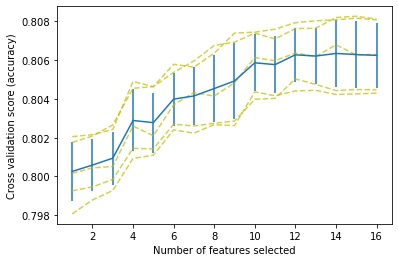

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv3bal.grid_scores_) + min_features_to_select),
    rfecv3bal.cv_results_['mean_test_score'], rfecv3bal.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv3bal.grid_scores_) + min_features_to_select),
    rfecv3bal.grid_scores_, 'y--', alpha = 0.7
)
plt.show()

In [ ]:
clf = LinearSVC(class_weight='balanced')
rfe4 = RFE(estimator = clf, n_features_to_select = 1)
rfe4.fit(X,y)

RFE(estimator=LinearSVC(class_weight='balanced'), n_features_to_select=1)

Show the feature importance rank

In [ ]:
ranking4 = rfe4.ranking_

In [ ]:
ranking4

array([12, 14,  6,  4,  5,  2,  3, 11,  7,  8,  9, 13, 16, 15, 10,  1])

In [ ]:
clf = LinearSVC(class_weight='balanced')
clf.fit(X,y)
a4 = clf.coef_
b4 = a4.tolist()[0]

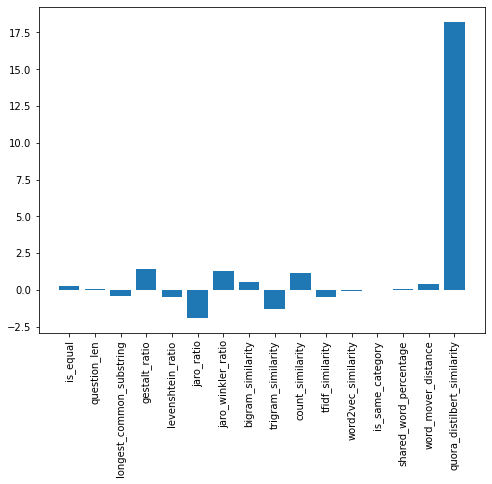

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(xlabel, b4)
plt.show()

# KNN

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = KNeighborsClassifier(n_neighbors=21)
knn_scores = cross_val_score(clf, Xres, yres, cv=skf)

In [ ]:
print("KNN: %0.3f accuracy with a standard deviation of %0.3f" % (bayes_scores.mean(), bayes_scores.std()))

# XGBoost 

Feature importance with original data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = XGBClassifier(random_state=0)
min_features_to_select = 1  # Minimum number of features to consider
rfecv5 = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv5.fit(X, y)

print("Optimal number of features : %d" % rfecv5.n_features_)

Optimal number of features : 13


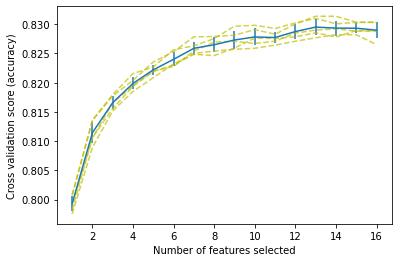

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv5.grid_scores_) + min_features_to_select),
    rfecv5.cv_results_['mean_test_score'], rfecv5.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv5.grid_scores_) + min_features_to_select),
    rfecv5.grid_scores_, 'y--', alpha = 0.7
)
plt.show()

Feature importance with resampled data 

In [ ]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring shows the proportion of correct classifications
clf = XGBClassifier(random_state=0)
min_features_to_select = 1  # Minimum number of features to consider
rfecv5bal = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv5bal.fit(Xres, yres)

print("Optimal number of features : %d" % rfecv5bal.n_features_)

Optimal number of features : 13


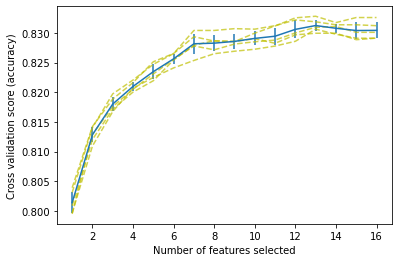

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv5bal.grid_scores_) + min_features_to_select),
    rfecv5bal.cv_results_['mean_test_score'], rfecv5bal.cv_results_['std_test_score']
)
plt.plot(
    range(min_features_to_select, len(rfecv5bal.grid_scores_) + min_features_to_select),
    rfecv5bal.grid_scores_, 'y--', alpha = 0.7
)
plt.show()

In [ ]:
clf= XGBClassifier(random_state=0)
rfe6 = RFE(estimator = clf, n_features_to_select = 1)
rfe6.fit(X,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            gamma=None, gpu_id=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=0, reg_alpha=None, reg_lambda=None, ...),
    n_features_to_select=1)

Show the feature importance rank

In [ ]:
ranking6 = rfe6.ranking_

In [ ]:
ranking6

array([16, 13,  3, 11,  7, 14, 10, 12, 15,  4,  6,  9,  8,  2,  5,  1])

In [ ]:
clf = XGBClassifier(random_state=0)
clf.fit(X,y)
a5 = clf.feature_importances_
b5 = a5.tolist()


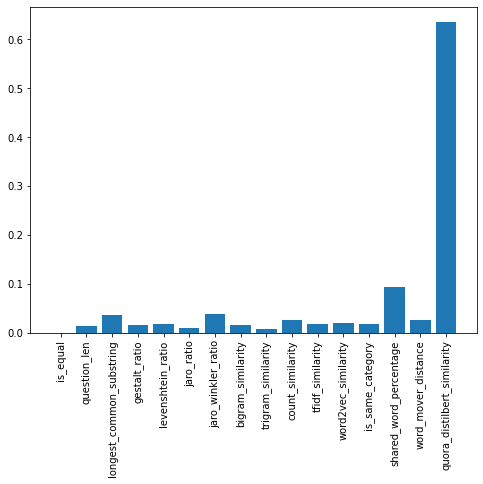

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(xlabel, b5)
plt.show()

# Naive Bayes 

In [ ]:
skf = StratifiedKFold(shuffle = True)

In [ ]:
gaussian_nb = GaussianNB()
bayes_scores = cross_val_score(gaussian_nb, Xres, yres, cv=skf)

In [ ]:
print("Naive Bayes: %0.3f accuracy with a standard deviation of %0.3f" % (bayes_scores.mean(), bayes_scores.std()))

Naive Bayes: 0.719 accuracy with a standard deviation of 0.002


# Consolidated

Feature importance with original data 

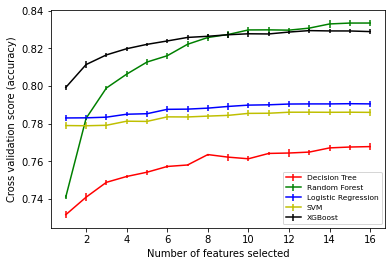

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'], rfecv.cv_results_['std_test_score'], label = 'Decision Tree', color = 'r')
plt.errorbar(
    range(min_features_to_select, len(rfecv1.grid_scores_) + min_features_to_select),
    rfecv1.cv_results_['mean_test_score'], rfecv1.cv_results_['std_test_score'], label = 'Random Forest' , color = 'g'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv2.grid_scores_) + min_features_to_select),
    rfecv2.cv_results_['mean_test_score'], rfecv2.cv_results_['std_test_score'], label = 'Logistic Regression',color = 'b'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv3.grid_scores_) + min_features_to_select),
    rfecv3.cv_results_['mean_test_score'], rfecv3.cv_results_['std_test_score'], label = 'SVM',color =  'y'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv5.grid_scores_) + min_features_to_select),
    rfecv5.cv_results_['mean_test_score'], rfecv5.cv_results_['std_test_score'], label = 'XGBoost', color = 'black' 
)
plt.legend(prop={'size': 7.5})

Feature importance with resampled data 

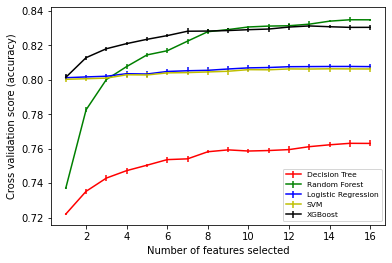

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.errorbar(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'], rfecv.cv_results_['std_test_score'], label = 'Decision Tree', color = 'r')
plt.errorbar(
    range(min_features_to_select, len(rfecv1bal.grid_scores_) + min_features_to_select),
    rfecv1bal.cv_results_['mean_test_score'], rfecv1bal.cv_results_['std_test_score'], label = 'Random Forest' , color = 'g'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv2bal.grid_scores_) + min_features_to_select),
    rfecv2bal.cv_results_['mean_test_score'], rfecv2bal.cv_results_['std_test_score'], label = 'Logistic Regression',color = 'b'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv3bal.grid_scores_) + min_features_to_select),
    rfecv3bal.cv_results_['mean_test_score'], rfecv3bal.cv_results_['std_test_score'], label = 'SVM',color =  'y'
)
plt.errorbar(
    range(min_features_to_select, len(rfecv5bal.grid_scores_) + min_features_to_select),
    rfecv5bal.cv_results_['mean_test_score'], rfecv5bal.cv_results_['std_test_score'], label = 'XGBoost', color = 'black' 
)
plt.legend(prop={'size': 7.5})

In [ ]:
print("Decision Tree: %0.3f accuracy with a standard deviation of %0.3f" %(rfecv.cv_results_['mean_test_score'][-1], rfecv.cv_results_['std_test_score'][-1]))
print("Random Forest: %0.3f accuracy with a standard deviation of %0.3f" %(rfecv1bal.cv_results_['mean_test_score'][-1], rfecv1bal.cv_results_['std_test_score'][-1]))
print("Logistic Regression: %0.3f accuracy with a standard deviation of %0.3f" %(rfecv2bal.cv_results_['mean_test_score'][-1], rfecv2bal.cv_results_['std_test_score'][-1]))
print("SVM: %0.3f accuracy with a standard deviation of %0.3f" %(rfecv3bal.cv_results_['mean_test_score'][-1], rfecv3bal.cv_results_['std_test_score'][-1]))
print("XGBoost: %0.3f accuracy with a standard deviation of %0.3f" %(rfecv5bal.cv_results_['mean_test_score'][-1], rfecv5bal.cv_results_['std_test_score'][-1]))
print("Naive Bayes: %0.3f accuracy with a standard deviation of %0.3f" % (bayes_scores.mean(), bayes_scores.std()))
print("KNN: %0.3f accuracy with a standard deviation of %0.3f" % (knn_scores.mean(), knn_scores.std()))

Decision Tree: 0.763 accuracy with a standard deviation of 0.002
Random Forest: 0.835 accuracy with a standard deviation of 0.001
Logistic Regression: 0.808 accuracy with a standard deviation of 0.002
SVM: 0.806 accuracy with a standard deviation of 0.002
XGBoost: 0.830 accuracy with a standard deviation of 0.001
Naive Bayes: 0.719 accuracy with a standard deviation of 0.002
KNN: 0.787 accuracy with a standard deviation of 0.001


Show the feature importance rank

In [ ]:
a = [ranking, ranking2, ranking3, ranking4, ranking6]

In [ ]:
print(a)
a[0][1]

[array([16, 10, 12,  6, 11,  4, 13,  7,  9, 14,  3,  5, 15,  8,  2,  1]), array([16, 13, 14,  5, 11, 12,  9,  6,  3, 10,  7,  8, 15,  4,  2,  1]), array([12, 13,  6,  4,  5,  2,  3, 11,  7,  8,  9, 14, 16, 15, 10,  1]), array([12, 14,  6,  4,  5,  2,  3, 11,  7,  8,  9, 13, 16, 15, 10,  1]), array([16, 13,  3, 11,  7, 14, 10, 12, 15,  4,  6,  9,  8,  2,  5,  1])]


10

Visualizing feature importance by model

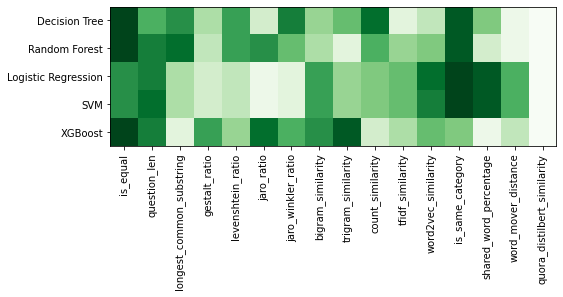

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ylabel = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM', 'XGBoost']
xlabel = feature_cols 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_yticks(np.arange(len(ylabel)))
ax.set_yticklabels(ylabel)
ax.set_xticklabels(xlabel, rotation = 90)
ax.imshow(a, cmap=plt.cm.Greens)
plt.show()


In [ ]:
sort = []
for i in range(len(feature_cols)):
    s = 0
    for j in range(len(ylabel)):
        s += a[j][i]
    sort.append((s, i))
sort.sort()
feature_cols_new = []
for i in sort:
    feature_cols_new.append(feature_cols[i[1]])
a_new = np.empty([len(ylabel), len(feature_cols)])
for i in range(len(ylabel)):
    index_new = 0
    for j in sort:
        index = j[1]
        a_new[i][index_new] = a[i][index]
        index_new += 1
print(a_new)

[[ 1.  2.  6.  4.  3. 13. 11. 12.  9. 14.  8.  7.  5. 10. 15. 16.]
 [ 1.  2.  5. 12.  7.  9. 11. 14.  3. 10.  4.  6.  8. 13. 15. 16.]
 [ 1. 10.  4.  2.  9.  3.  5.  6.  7.  8. 15. 11. 14. 13. 16. 12.]
 [ 1. 10.  4.  2.  9.  3.  5.  6.  7.  8. 15. 11. 13. 14. 16. 12.]
 [ 1.  5. 11. 14.  6. 10.  7.  3. 15.  4.  2. 12.  9. 13.  8. 16.]]


Visualizing feature importance by model

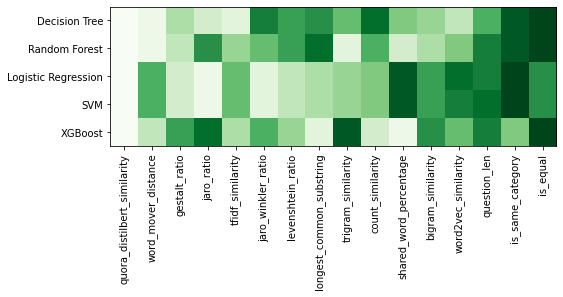

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ylabel = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM', 'XGBoost']
xlabel = feature_cols_new 
ax.set_xticks(np.arange(len(xlabel)))
ax.set_yticks(np.arange(len(ylabel)))
ax.set_yticklabels(ylabel)
ax.set_xticklabels(xlabel, rotation = 90)
ax.imshow(a_new, cmap=plt.cm.Greens)
plt.show()

Visualizing feature importance

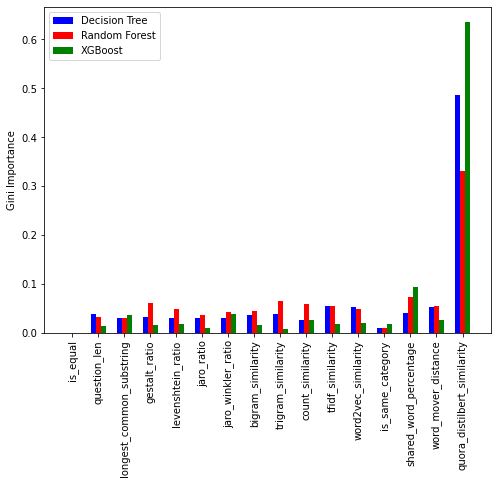

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols
X_axis = np.arange(len(feature_cols))
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(X_axis-0.2, b1, 0.2, color = 'b', label = 'Decision Tree')
ax.bar(X_axis, b2, 0.2, color = 'r', label = 'Random Forest')
ax.bar(X_axis+0.2, b5, 0.2, color = 'g', label = 'XGBoost')
ax.legend()
plt.ylabel('Gini Importance')
plt.show()

In [ ]:
print('Variance of decision tree is: %f' %(np.var(b1)))
print('Variance of Random forest is: %f' %(np.var(b2)))

Variance of decision tree is: 0.012170
Variance of Random forest is: 0.005125


Visualizing feature importance without `quora_dostilbert_similarity`

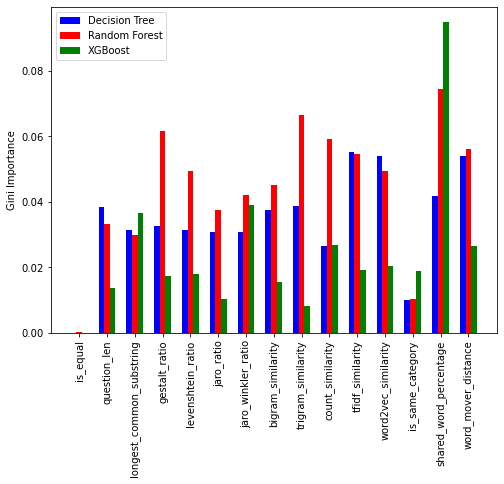

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols[:-1]
X_axis = np.arange(len(feature_cols)-1)
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(X_axis-0.2, b1[:-1], 0.2, color = 'b', label = 'Decision Tree')
ax.bar(X_axis, b2[:-1], 0.2, color = 'r', label = 'Random Forest')
ax.bar(X_axis+0.2, b5[:-1], 0.2, color = 'g', label = 'XGBoost')
ax.legend()
plt.ylabel('Gini Importance')
plt.show()

In [ ]:
b3[:-1]

[0.7262658767671617,
 0.29756757232745557,
 -1.2320110347874904,
 3.7303852871452916,
 -1.080807966936526,
 -4.981209726820691,
 3.187013700283798,
 1.4275528630814638,
 -3.553714000047293,
 3.2636195068267146,
 -1.3035321593627365,
 -0.18195243201896213,
 0.027155955400434768,
 0.06418142710440662,
 1.1803463515698804]

Visualize weight assigned to features

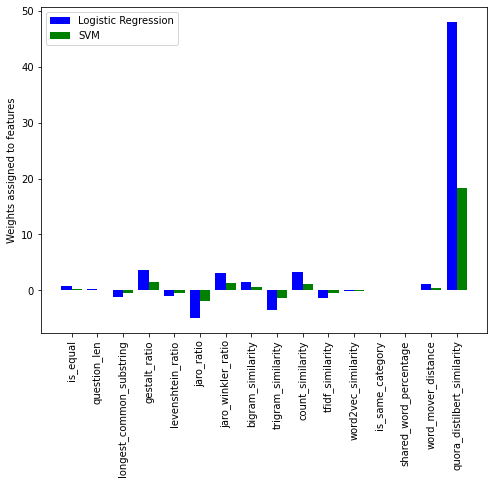

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols
X_axis = np.arange(len(feature_cols))
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(X_axis-0.2, b3, 0.4, color = 'b', label = 'Logistic Regression')
ax.bar(X_axis+0.2, b4, 0.4, color = 'g', label = 'SVM')
ax.legend()
plt.ylabel('Weights assigned to features')
plt.show()

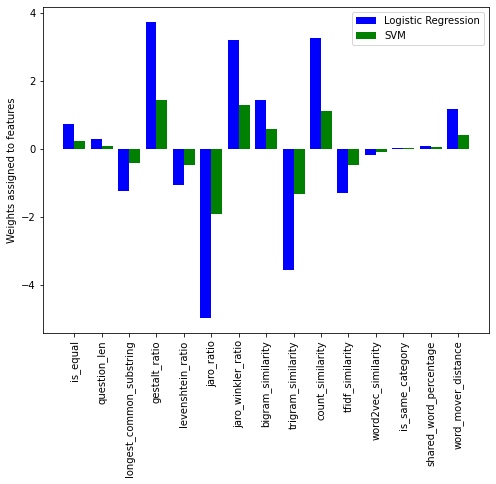

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
xlabel = feature_cols[:-1]
X_axis = np.arange(len(feature_cols)-1)
ax.set_xticks(np.arange(len(xlabel)))
ax.set_xticklabels(xlabel, rotation = 90)
ax.bar(X_axis-0.2, b3[:-1], 0.4, color = 'b', label = 'Logistic Regression')
ax.bar(X_axis+0.2, b4[:-1], 0.4, color = 'g', label = 'SVM')
ax.legend()
plt.ylabel('Weights assigned to features')
plt.show()

# PCA

Use PCA to reduce dimension and visual the features

In [ ]:
plt.cla()
pca = PCA(n_components=3)
pca.fit(X)
X

,is_equal,question_len,longest_common_substring,gestalt_ratio,levenshtein_ratio,jaro_ratio,jaro_winkler_ratio,bigram_similarity,trigram_similarity,count_similarity,tfidf_similarity,word2vec_similarity,is_same_category,shared_word_percentage,word_mover_distance,quora_distilbert_similarity
0,False,0.866667,0.750000,0.923077,0.923077,0.952381,0.971429,0.860465,0.822222,0.942809,0.979549,0.931028,1,0.857143,0.198042,0.974921
1,False,0.687500,0.416667,0.615385,0.615385,0.652389,0.652389,0.413333,0.367089,0.615457,0.796109,0.487836,1,0.300000,1.146997,0.932612
2,False,0.733333,0.142857,0.560976,0.560976,0.775325,0.820260,0.473684,0.409836,0.365148,0.277362,0.777991,1,0.300000,0.694896,0.929791
3,False,0.684211,0.066667,0.191781,0.246575,0.480201,0.480201,0.027397,0.013158,0.000000,0.000000,0.345831,0,0.090909,1.261312,0.714403
4,False,0.500000,0.076923,0.258065,0.430108,0.618763,0.618763,0.217949,0.141176,0.282843,0.230050,0.630007,1,0.214286,0.972994,0.864697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,False,0.933333,0.250000,0.928571,0.928571,0.876437,0.925862,0.809524,0.784615,0.857143,0.712378,0.868354,1,0.777778,0.194770,0.967440
404286,False,0.900000,0.000000,0.742857,0.742857,0.729673,0.729673,0.541667,0.500000,0.666667,0.632863,0.870961,0,0.600000,0.393355,0.995816
404287,False,1.000000,0.000000,0.750000,0.750000,0.785714,0.785714,0.500000,0.428571,0.707107,0.879741,0.808205,1,0.500000,0.658809,0.932106
404288,False,0.678571,0.062500,0.349650,0.391608,0.610780,0.610780,0.150794,0.042553,0.000000,0.000000,0.291767,0,0.043478,1.315823,0.741905


In [ ]:
Xp = pca.transform(X)

In [ ]:
undersize = data[data.is_duplicate == 1].shape[0]
data2 = data[data.is_duplicate == 0].sample(n = undersize).append(data[data.is_duplicate == 1])

In [ ]:
feature_cols = ['question_len',
       'longest_common_substring', 'gestalt_ratio', 'levenshtein_ratio',
       'jaro_ratio', 'jaro_winkler_ratio', 'bigram_similarity',
       'trigram_similarity', 'count_similarity', 'tfidf_similarity',
       'word2vec_similarity', 'shared_word_percentage',
       'word_mover_distance', 'quora_distilbert_similarity']
X = data2[feature_cols]
y = data2.is_duplicate

Plot of PCA reduce to 3 dimensions

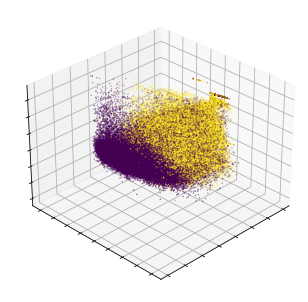

In [ ]:
plt.cla()
pca = PCA(n_components=3)
pca.fit(X)
Xp = pca.transform(X)
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = fig.add_subplot(111, projection="3d", elev=30, azim=45)
ax.set_position([0, 0, 0.95, 1])
ax.scatter(Xp[:, 0], Xp[:, 1], Xp[:, 2], s = 0.1, c=y)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

Plot of PCA reduce to 2 dimensions

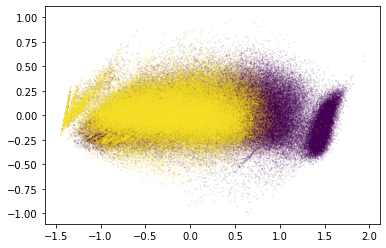

In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(X)
Xp = pca.transform(X)

plt.clf()

plt.scatter(Xp[:, 0], Xp[:, 1], s=0.005, c=y)

plt.show()

# LDA

Use LDA to reduce dimension to visualize the features

In [ ]:
lda = LinearDiscriminantAnalysis(n_components = 1)
X_r2 = lda.fit(X, y).transform(X)
X_r2

array([[ 1.22168451],
       [ 3.63428891],
       [ 1.05728868],
       ...,
       [-0.56743861],
       [-1.12464536],
       [-1.25030038]])

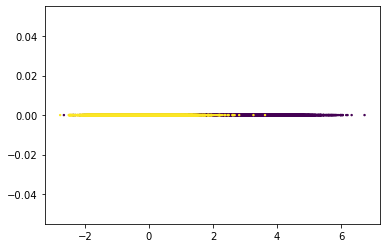

In [ ]:
ar = np.arange(len(X_r2)) # just as an example array

plt.scatter(X_r2, np.zeros_like(ar), c=y , s=2)
plt.show()

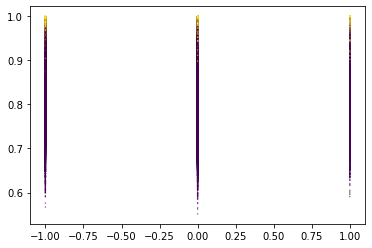

In [ ]:
plt.scatter(X['is_same_category'], X['quora_distilbert_similarity'], s = 0.1, c = y)